In [ ]:
cd /autodl-fs/data/DiffusionFastForward-master/

In [ ]:
CUDA_LAUNCH_BLOCKING=1 python your_script.py

In [ ]:
!pip install wandb

In [ ]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

# PyTorch Lightning (推荐最新稳定版)
!pip install pytorch-lightning==2.2.4 diffusers einops kornia

# 其他必备库
!pip install wandb matplotlib numpy imageio scikit-image torch-fidelity

In [ ]:
pip install lpips           # 或者 conda install -c conda-forge lpips

In [1]:
import wandb
wandb.login(key='ed59af71ef4ffd0dd466bc2b9a705a6c24feffbd')

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


True

wandb: Network error (ConnectTimeout), entering retry loop.


In [ ]:
wandb.finish()

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [29]:
cd autodl-fs/data/clash

[Errno 2] No such file or directory: 'autodl-fs/data/clash'
/autodl-fs/data


In [30]:
ls /autodl-fs/data/clash/

Clash-For-Ubuntu-main.zip  FlyingBird_1749062269.yaml  clash.gz


# Conditional Latent Diffusion Training

In this notebook, we will train a simple `LatentDiffusionConditional` model in low resolution (64 by 64).

The training should take about 20 hours for reasonable results.

---

Maps dataset from the pix2pix paper:
```bash
wget http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/maps.tar.gz
tar -xvf maps.tar.gz
```

In [2]:
import os, requests
print(os.environ.get("http_proxy"))


None


In [2]:
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger, CSVLogger   # ← 同时导入 CSVLogger
from pytorch_lightning import Trainer
import torch
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import imageio
from skimage import io
import os
from src import *

mpl.rcParams['figure.figsize'] = (8, 8)

In [3]:
import kornia
from kornia.utils import image_to_tensor
import kornia.augmentation as KA

class SimpleImageDataset(Dataset):
    """Dataset returning images in a folder."""

    def __init__(self,
                 root_dir,
                 transforms=None,
                 paired=True,
                 return_pair=False):
        self.root_dir = root_dir
        self.transforms = transforms
        self.paired=paired
        self.return_pair=return_pair
        
        # set up transforms
        if self.transforms is not None:
            if self.paired:
                data_keys=2*['input']
            else:
                data_keys=['input']

            self.input_T=KA.container.AugmentationSequential(
                *self.transforms,
                data_keys=data_keys,
                same_on_batch=False
            )   
        
        # check files
        supported_formats=['webp','jpg']        
        self.files=[el for el in os.listdir(self.root_dir) if el.split('.')[-1] in supported_formats]

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()            

        img_name = os.path.join(self.root_dir,
                                self.files[idx])
        image = image_to_tensor(io.imread(img_name))/255

        if self.paired:
            c,h,w=image.shape
            slice=int(w/2)
            image2=image[:,:,slice:]
            image=image[:,:,:slice]
            if self.transforms is not None:
                out = self.input_T(image,image2)
                image=out[0][0]
                image2=out[1][0]
        elif self.transforms is not None:
            image = self.input_T(image)[0]

        if self.return_pair:
            return image,image2
        else:
            return image

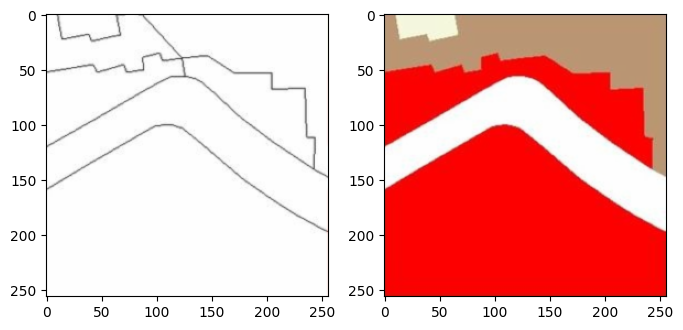

In [4]:
import torchvision.transforms as T

CROP_SIZE=256

T=[
    KA.RandomCrop((2*CROP_SIZE,2*CROP_SIZE)),
    KA.Resize((CROP_SIZE,CROP_SIZE),antialias=True),
    KA.RandomVerticalFlip()
  ]

train_ds=SimpleImageDataset('/autodl-fs/data/20250313yangben/2/xk_256/train',
                      transforms=T,
                      return_pair=True
                     )

test_ds=SimpleImageDataset('/autodl-fs/data/20250313yangben/2/xk_256/val',
                      transforms=T,
                      return_pair=True
                     )

img1,img2=train_ds[0]

plt.subplot(1,2,1)
plt.imshow(img1.permute(1,2,0))
plt.subplot(1,2,2)
plt.imshow(img2.permute(1,2,0))

In [11]:
from pytorch_lightning.callbacks import ModelCheckpoint

checkpoint_callback = ModelCheckpoint(
    monitor='loss_diff',
    dirpath='/autodl-fs/data/checkpoints166000/',
    filename='best-diff-{epoch:02d}-{loss_diff:.4f}',
    save_top_k=1,
    mode='min',
    save_on_train_epoch_end=True,   # 或者根据你的需求改成 save_on_train_step、every_n_train_steps 等
    save_weights_only=False,
)

### Model Training

In [5]:
ls /autodl-fs/data/checkpoints/

'epoch=0-step=1000.ckpt'  'epoch=2-step=5000.ckpt'
'epoch=0-step=2000.ckpt'  'epoch=445-step=500000.ckpt'
'epoch=0-step=250.ckpt'   'epoch=5-step=3000.ckpt'
'epoch=0-step=562.ckpt'   'epoch=6-step=15701.ckpt'
'epoch=1-step=1000.ckpt'  'epoch=89-step=200000.ckpt'
'epoch=1-step=3000.ckpt'   step000900-ld0.0016.ckpt
'epoch=1-step=5700.ckpt'


In [5]:
checkpoint_path = "/autodl-fs/data/checkpoints/epoch=445-step=500000.ckpt"
model = LatentDiffusionConditional.load_from_checkpoint(checkpoint_path, train_dataset=train_ds, lr=1e-4, batch_size=64,strict=False)

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 23.65 GiB of which 4.50 MiB is free. Process 832163 has 23.20 GiB memory in use. Process 884449 has 448.00 MiB memory in use. Of the allocated memory 54.12 MiB is allocated by PyTorch, and 9.88 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

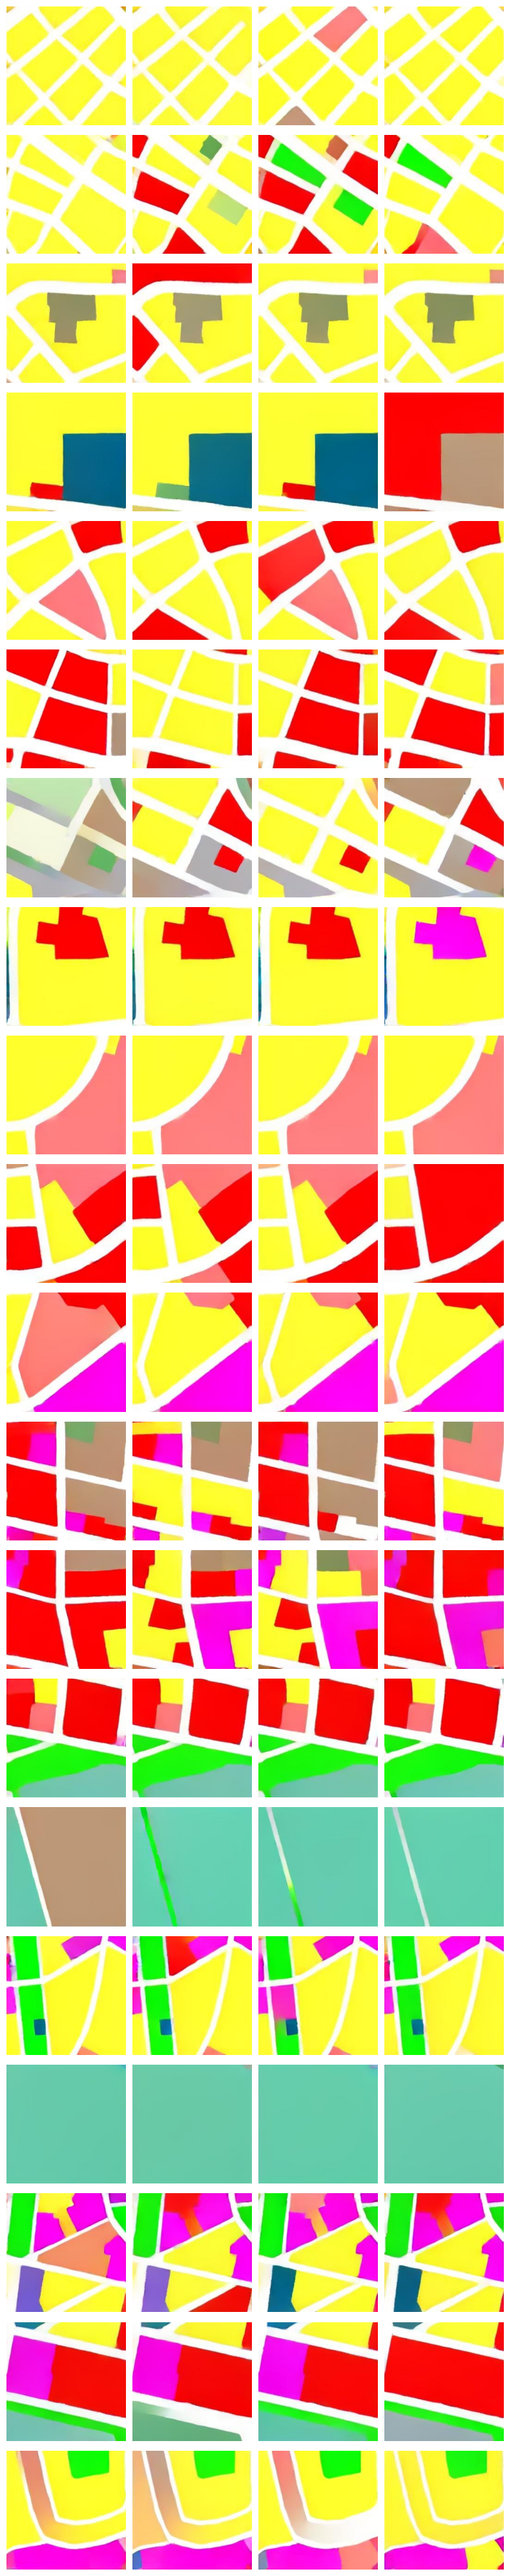

In [35]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# ———————— 1. 配置路径 ————————
# 把这里改成你本地的结果文件夹路径
result_dir = "/autodl-fs/data/00-test/pinggu/results250"

# ———————— 2. 列出所有图片文件名并分组 ————————
all_files = sorted([
    f for f in os.listdir(result_dir)
    if f.lower().endswith((".jpg", ".jpeg", ".png", ".bmp"))
])

# 按名字前十个字符分组
groups = {}
for fname in all_files:
    prefix = fname[:10]
    groups.setdefault(prefix, []).append(fname)

# 确认一共有 20 个组，每组 4 张
prefixes = sorted(groups.keys())
assert len(prefixes) == 20, f"预期有 20 个不同的前十字符前缀，实际找到了 {len(prefixes)} 个"
for p in prefixes:
    assert len(groups[p]) == 4, f"前缀 {p} 对应的图片数量不是 4 张，而是 {len(groups[p])} 张"

# ———————— 3. 在 20×4 网格上显示所有图片（用 plt.subplot 方式） ————————
n_rows = 20
n_cols = 4

# 新建一个大画布，大小根据网格行列数自行调整
fig = plt.figure(figsize=(n_cols * 2, n_rows * 2))  # 每个子图大约 2×2 英寸，整个图看起来更紧凑

# 下面这句相当于为整个画布设定列间距和行间距：
#   left/right/top/bottom 控制画布四周留白，wspace/hspace 控制子图之间的间距


# 按行遍历每个 prefix，再按列遍历这一组中的 4 张图
for row_idx, prefix in enumerate(prefixes):
    file_list = sorted(groups[prefix])  # 排序后保证 4 张图顺序固定
    for col_idx in range(n_cols):
        # ❶ 计算当前子图在 20×4 网格中的“编号”
        #    index 从 1 开始，到 n_rows*n_cols 结束
        index = row_idx * n_cols + col_idx + 1
        
        # ❷ 在第 index 个位置新建子图
        plt.subplot(n_rows, n_cols, index)
        
        # ❸ 读取、显示图片
        img_path = os.path.join(result_dir, file_list[col_idx])
        img = Image.open(img_path).convert("RGB")
        plt.imshow(img)
        plt.axis("off")

# ❹ 紧凑布局（只会微调边缘，不会改变我们上面设的 wspace/hspace）
plt.tight_layout()
plt.show()


In [5]:
model=LatentDiffusionConditional(train_ds,
                                 lr=1e-4,
                                 batch_size=16)

Is Time embed used ?  True
Is Time embed used ?  True


...but first, let's check if the used `AutoEncoder` (`model.ae`) can reconstruct our samples well.

**You should always test your autoencoder in this way when using latent diffusion models on a new dataset.**

In [16]:
from pytorch_lightning import Trainer
from src.EMA import EMA

trainer = Trainer(
    max_steps=1500,
    callbacks=[EMA(0.9999)],
    precision=16,
    log_every_n_steps=1,
    accelerator="gpu",         # 指明使用 GPU
    devices=[0],               # 或者 devices=1，表示第 0 号卡
    num_sanity_val_steps=0, # ← 设为 0 就会跳过那几步的 sanity check
)


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model)
wandb.finish()

In [ ]:
# epoch88test diff-GANloss
checkpoint_path = "/home/w108/Downloads/diff-gan/epoch=0-step=1000.ckpt"
model = LatentDiffusionConditional.load_from_checkpoint(checkpoint_path, train_dataset=train_ds, lr=1e-4, batch_size=8)

In [7]:
# 单张
input,output=test_ds[0]
batch_input=torch.stack(4*[input],0)

model.cuda()
out=model(batch_input, verbose=True)

diffusion sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

In [6]:
model.cuda()
# 取 val_ds 中索引 0–5 的 6 张图，并复制 4 次，stack 成 (24, C, H, W)
batch_input = torch.stack([ test_ds[i][0] for i in range(6) ] * 4, dim=0).cuda()
out = model(batch_input, verbose=True)

diffusion sampling:   0%|          | 0/1000 [00:00<?, ?it/s]

By default, the `DDPM` sampler contained in the model is used, as above.

However, you can use a `DDIM` sampler just as well to reduce the number of inference steps:

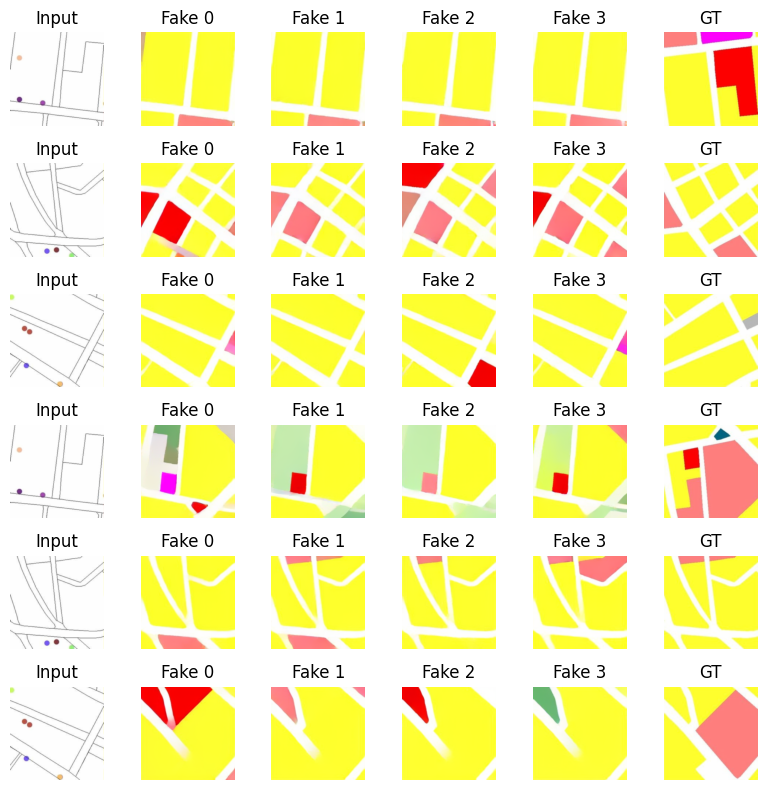

In [7]:
batch_gt = torch.stack([test_ds[i][1] for i in range(6)], dim=0)  # (6, C, H, W)
steps = 4                 # 每张图喂 4 次
ncols = 2 + steps         # Input + Fake×4 + GT
plt.figure()          # ❶ 把画布改高

for row in range(6):                           # ❷ 行循环
    #—— Input
    plt.subplot(6, ncols, row*ncols + 1)       # ❸ 行偏移
    plt.imshow(batch_input[row*4].cpu().clamp(0,1).permute(1,2,0))  # Use row*4 since batch_input has repeated images
    plt.title('Input'); plt.axis('off')

    #—— 4 张 Fake
    for k in range(steps):
        idx = row + k*6                        # (row, k) → out 索引
        plt.subplot(6, ncols, row*ncols + 2 + k)
        plt.imshow(out[idx].detach().cpu().clamp(0,1).permute(1,2,0))
        plt.title(f'Fake {k}'); plt.axis('off')

    #—— GT
    plt.subplot(6, ncols, row*ncols + ncols)
    plt.imshow(batch_gt[row].cpu().clamp(0,1).permute(1,2,0))
    plt.title('GT'); plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
img = test_ds[0][1]
print(type(img))


In [ ]:
import torchmetrics as tm
from lpips import LPIPS
import torch
# from PIL import ImageOps # Not used in this selection
# from torchvision.transforms import ToTensor # Not needed as test_ds[i][1] is already a tensor

device = 'cuda' if torch.cuda.is_available() else 'cpu'
steps = 4

# gt_tensors will store ground truth images on the specified device
gt_tensors = []
for i in range(6):
    # Get ground truth image tensor.
    # Based on the error "TypeError: pic should be PIL Image or ndarray. Got <class 'torch.Tensor'>",
    # test_ds[i][1] is already a torch.Tensor.
    gt_img_tensor = test_ds[i][1]
    
    # Ensure it's a tensor (though the error implies it is) and move to device
    if not isinstance(gt_img_tensor, torch.Tensor):
        # This case should not be reached if the error diagnosis is correct.
        # If test_ds[i][1] could sometimes be a PIL Image, ToTensor would be needed here.
        # For now, assuming it's always a tensor as per the error.
        raise ValueError(f"Expected test_ds[{i}][1] to be a torch.Tensor, but got {type(gt_img_tensor)}")

    t = gt_img_tensor.to(device)
    gt_tensors.append(t)

# Stack ground truth tensors
gt_imgs = torch.stack(gt_tensors) # gt_imgs is now on 'device'

# Process predictions
# 'out' is assumed to be from the previous cell, potentially on a different device
pred_imgs = out.to(device)  # shape [steps*6, C, H, W]
batch_size = gt_imgs.shape[0] # This should be 6
# Reshape predictions to [steps, batch_size, C, H, W]
pred_steps = pred_imgs.view(steps, batch_size, *pred_imgs.shape[1:])

# Initialize metrics
lpips_fn = LPIPS(net='vgg').to(device).eval()
ssim_fn  = tm.image.ssim.StructuralSimilarityIndexMeasure(data_range=1.0).to(device) # Use float for data_range
psnr_fn  = tm.image.psnr.PeakSignalNoiseRatio(data_range=1.0).to(device) # Use float for data_range

# Track best scores
best = {
    'fid':   (float('inf'), -1),
    'ssim':  (-float('inf'), -1),
    'psnr':  (-float('inf'), -1),
    'lpips': (float('inf'), -1),
}

for k in range(steps):
    preds_k = pred_steps[k].clamp(0, 1)  # [B,C,H,W], already on 'device'
    gts     = gt_imgs                    # [B,C,H,W], already on 'device'


    fid_fn = tm.image.fid.FrechetInceptionDistance(feature=2048, normalize=False).to(device)
    
    # Convert tensors to ByteTensor [0,255] for FID calculation
    gts_byte = (gts * 255).byte()
    preds_k_byte = (preds_k * 255).byte()
    
    fid_fn.update(gts_byte, real=True)
    fid_fn.update(preds_k_byte, real=False)
    fid_k = fid_fn.compute().item()

    # Calculate SSIM and PSNR (inputs are float [0,1])
    ssim_k = ssim_fn(preds_k, gts).item()
    psnr_k = psnr_fn(preds_k, gts).item()

    # Calculate LPIPS (inputs are float [-1,1])
    with torch.no_grad():
        lpips_k = lpips_fn(preds_k * 2 - 1, gts * 2 - 1).mean().item()

    # Update best scores
    if fid_k < best['fid'][0]:
        best['fid'] = (fid_k, k)
    if ssim_k > best['ssim'][0]:
        best['ssim'] = (ssim_k, k)
    if psnr_k > best['psnr'][0]:
        best['psnr'] = (psnr_k, k)
    if lpips_k < best['lpips'][0]:
        best['lpips'] = (lpips_k, k)

# Print best scores
print(f"最佳 FID   = {best['fid'][0]:.4f}  出现在 step {best['fid'][1]}")
print(f"最佳 SSIM  = {best['ssim'][0]:.4f}  出现在 step {best['ssim'][1]}")
print(f"最佳 PSNR  = {best['psnr'][0]:.2f} dB 出现在 step {best['psnr'][1]}")
print(f"最佳 LPIPS = {best['lpips'][0]:.4f}  出现在 step {best['lpips'][1]}")

# Visualize results
import matplotlib.pyplot as plt

# Determine which step's predictions to plot, fallback to 0 if no valid FID step found
step_to_plot = best['fid'][1] if best['fid'][1] != -1 else 0
if step_to_plot >= steps or step_to_plot < 0: # Additional safety for step_to_plot index
    step_to_plot = 0


# Get predictions and ground truth for the chosen step, move to CPU for plotting
preds_k_to_plot = pred_steps[step_to_plot].clamp(0, 1).cpu()  # shape [B, C, H, W]
gts_to_plot     = gt_imgs.cpu() # shape [B, C, H, W]

# Plot results
num_images = preds_k_to_plot.shape[0]
fig_height = 2 * num_images if num_images > 0 else 2 # Avoid zero height
plt.figure(figsize=(8, fig_height)) # Adjust figure size for better layout

for i in range(num_images):
    # Ground truth
    plt.subplot(num_images, 2, i * 2 + 1)
    plt.imshow(gts_to_plot[i].permute(1, 2, 0).clamp(0,1))  # CHW → HWC
    plt.title(f"GT {i}")
    plt.axis("off")

    # Prediction
    plt.subplot(num_images, 2, i * 2 + 2)
    plt.imshow(preds_k_to_plot[i].permute(1, 2, 0).clamp(0,1))
    plt.title(f"Pred Step {step_to_plot} - Img {i}")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
input,output=test_ds[0]
batch_input=torch.stack(4*[input],0)

model.cuda()
out=model(batch_input, verbose=True)

In [ ]:
plt.subplot(1,2+len(out),1)
plt.imshow(input.permute(1,2,0))
plt.title('Input')
plt.axis('off')
for idx in range(out.shape[0]):
    plt.subplot(1,2+len(out),idx+2)
    plt.imshow(out[idx].detach().cpu().permute(1,2,0))
    plt.axis('off')
plt.subplot(1,2+len(out),2+len(out))
plt.imshow(output.permute(1,2,0))
plt.title('Ground Truth')
plt.axis('off')

In [ ]:
input,output=test_ds[0]
batch_input=torch.stack(4*[input],0)
STEPS=200 # ddim steps

ddim_sampler=DDIM_Sampler(STEPS,model.model.num_timesteps)

model.cuda()
out=model(batch_input,sampler=ddim_sampler,verbose=True)

In [ ]:
plt.subplot(1,2+len(out),1)
plt.imshow(input.permute(1,2,0))
plt.title('Input')
plt.axis('off')
for idx in range(out.shape[0]):
    plt.subplot(1,2+len(out),idx+2)
    plt.imshow(out[idx].detach().cpu().permute(1,2,0))
    plt.axis('off')
plt.subplot(1,2+len(out),2+len(out))
plt.imshow(output.permute(1,2,0))
plt.title('Ground Truth')
plt.axis('off')